# Content
[Introduction](#Introduction) <br>

[Part 1. Mapping 2018 Toronto Rental Price with folium](#Part1) <br>

[Part 2. Webscraping data from City of Toronto website](#part2) <br>

[Part 3. Analyzing and visualizing scraped data](#part3) <br>

[Discussion](#discussion)


<a id='Introduction'></a>
# Introduction <br>
This project was inspired by personal affair. Due to the lastest policies from the school, I was going to relocate myself to Toronto and I wondered how rental pricing distributed generally in Toronto. Consequently, I collected a dataset with geographical information from Kaggle and scraped data from City of Toronto website to analyze rental price based on unit type.<br>
<br>


---


Thus, this project aims to <br>


1.   Use historical data (2018) from Kaggle to mapping Toronto rental price
2.   Scrape from City of Toronto website to retrieve the lastest data
3.   Analyze and Visualize 2021 Rental Price, Consolidate Personal Decision


---



---










In [2]:
# Import libraries
import numpy as np
import pandas as pd
import zipfile

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Webscraping
import requests
import re
from bs4 import BeautifulSoup

# Set display options
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_colwidth", 200)

# Load Kaggle Dataset:
with open('Toronto_apartment_rentals_2018.csv','r') as f:
    df = pd.read_csv(f, index_col = None)

<a id='Part1'></a>
# 1. Mapping 2018 Toronto Rental Price with folium
<a id='Part1'></a>

Here is the snippet of the Kaggle dataset:

In [3]:
df.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mississauga, ON L5B 0H8, Canada",43.581639,-79.648193,"$2,450.00"
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,"$2,150.00"
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,"$1,950.00"
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,"$2,900.00"
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,"$1,800.00"


Let's check if there is null value throughout dataset.

In [4]:
df.isnull().sum()

Bedroom     0
Bathroom    0
Den         0
Address     0
Lat         0
Long        0
Price       0
dtype: int64

Then, check data type for each column.

In [5]:
df.dtypes

Bedroom       int64
Bathroom    float64
Den           int64
Address      object
Lat         float64
Long        float64
Price        object
dtype: object

The data type for Price is incorrect due to presence of dollar sign. <br> To correct it, I remove the dollar sign and convert data type to 'float'.

In [6]:
df['Price'] = df['Price'].apply(lambda x: x.replace("$","").replace(",",""))
df['Price'] = pd.to_numeric(df['Price'],errors='coerce')
df['Price'].dtypes

dtype('float64')

Let's examine Price column to see if there is any abnormal values or outliers.

In [7]:
df['Price'].describe()

count      1124.000000
mean       3627.912811
std       27530.542058
min          65.000000
25%        1759.250000
50%        2100.000000
75%        2500.000000
max      535000.000000
Name: Price, dtype: float64

In [8]:
df[df['Price']>5000]

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
129,1,1.0,0,"101 Charles St, TORONTO, ON, M4Y 1V2",43.669593,-79.380580,535000.0
238,1,1.0,0,"101 Charles St, TORONTO, ON, M4Y 1V2",43.669593,-79.380580,535000.0
371,1,1.0,0,"101 Charles St, TORONTO, ON, M4Y 1V2",43.669593,-79.380580,535000.0
845,2,3.0,0,"180 University Ave, Toronto, ON M5H 0A2, Canada",43.648953,-79.385768,6500.0
917,2,1.0,0,", TORONTO M4T 1P3 ON, Canada",43.690463,-79.381576,36900.0
922,3,2.0,0,", toronto M5V 3z4 ON, Canada",43.641012,-79.394948,6000.0
952,2,2.5,0,"311 Bay St, Toronto, ON M5H 4G5, Canada",43.649783,-79.380440,9750.0
1096,3,2.0,0,"21 Widmer St, Toronto, ON M5V 0B8, Canada",43.647226,-79.391100,8000.0


I find out four records (index 129, 238,371, 917) with abnormal values. The prices are simply not compatible with unit features (number of bedroom, bathroom and den). Therefore, I remove these four records from the data frame.

In [9]:
df = df.drop(df[df['Price'] > 10000].index)
df['Price'].describe()

count    1120.000000
mean     2174.887500
std       741.755044
min        65.000000
25%      1757.000000
50%      2100.000000
75%      2500.000000
max      9750.000000
Name: Price, dtype: float64

Now, let's visualize 2018 rental price with a heatmap

In [11]:
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

I firstly retrieve geographical coordinate of Toronto via Nominatim, a open-source geocoding API.

In [12]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto are 43.6534817, -79.3839347.


I generate the lists of latitudes and longitudes from the dataset.

In [13]:
lats = [x for x in df['Lat']]
longs = [y for y in df['Long']]

Then I generate the Toronto map with heatmap feature to visualize price level.

In [14]:
tile = "CartoDB Positron" # use CartoDB Positron to reduce misleading colors from map itself without sacrificing district/municipality information

map_toronto = folium.Map(location=[latitude,longitude], tiles = tile, zoom_start=11)

# create heatmap layer
heatmap = HeatMap( list(zip(lats, longs, df["Price"])),
                   min_opacity=0.2,
                   max_val=df["Price"].max(),
                   radius=30, blur=40, max_zoom=1)
# add headmap layer to base map layer
heatmap.add_to(map_toronto)

# add a specific marker to base map layer
folium.Marker

map_toronto

<ipython-input-14-c7aa1d581c99>:6: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heatmap = HeatMap( list(zip(lats, longs, df["Price"])),


Based on the resulted map shown above, downtown Toronto had the highest range of rental prices. The neighbor cities, Mississauga and Markham, also have heated price range compared to other regions and areas. <br>





There is a small area between Etobicoke and Downtoan Toronto with heated price. It is most likely because of walking distance to the Humber Bay Park and adjacent business zone, which provides massive conveniouce to tenants.

---
By zooming in, the building is located at Lake Shore Blvd. I use keywords to retrieve geographical information. <br>

Let's dive into this neighborhood, **Humber Bay Shores**, and look up venue inforamtion with Foursquare API.

In [15]:
df[df['Address'].str.contains("Lake Shore")]
# the result shows repetitive data of the same place.

mark_lat = df.loc[663,'Lat']
mark_long = df.loc[663,'Long']

Prepare API authentification info.

In [16]:
CLIENT_ID = open('mykeys.txt').readlines()[1].strip('\n') # your Foursquare ID
CLIENT_SECRET = open('mykeys.txt').readlines()[2] # your Foursquare Secret
VERSION = '20211010' # Foursquare API version
# personal information is replaced for privacy

LIMIT = 100
RADIUS = 500

In [17]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            mark_lat, 
            mark_long, 
            RADIUS, 
            LIMIT)
            
# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
        
# return only relevant information for each nearby venue
venues_list = []
name = 'Humber Bay Shores'
venues_list.append([(
    name, 
    mark_lat, 
    mark_long, 
    v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood', 
          'Neighborhood Latitude', 
          'Neighborhood Longitude', 
          'Venue', 
          'Venue Latitude', 
          'Venue Longitude', 
          'Venue Category']

In [18]:
nearby_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Humber Bay Shores,43.627447,-79.478374,Lola's Gelato,43.627134,-79.478363,Gelato Shop
1,Humber Bay Shores,43.627447,-79.478374,Humber Bay Shores Park,43.627282,-79.476620,Park
2,Humber Bay Shores,43.627447,-79.478374,krazy roll,43.625837,-79.477113,Sushi Restaurant
3,Humber Bay Shores,43.627447,-79.478374,Eden Trattoria,43.627035,-79.476776,Italian Restaurant
4,Humber Bay Shores,43.627447,-79.478374,firkin on the bay,43.626584,-79.476959,Bar
5,Humber Bay Shores,43.627447,-79.478374,Pet Valu,43.629905,-79.480825,Pet Store
6,Humber Bay Shores,43.627447,-79.478374,LCBO,43.630094,-79.481985,Liquor Store
7,Humber Bay Shores,43.627447,-79.478374,Booster Juice,43.629926,-79.481996,Smoothie Shop
8,Humber Bay Shores,43.627447,-79.478374,Rabba Fine Foods,43.626759,-79.479542,Grocery Store
9,Humber Bay Shores,43.627447,-79.478374,TD Canada Trust,43.630595,-79.482256,Bank


In [19]:
num_ven_cat = len(nearby_venues['Venue Category'].unique())
print(f"There are in total {num_ven_cat} different venue categories at Humber Bay Shores")

There are in total 17 different venue categories at Humber Bay Shores


A variety of venues surrounds Humber Bay Shores, and tenants in this neighborhood are able to use diverse services in their daily lives. Consequently, they are charged with premium regarding the rental prices.

<a id='part2'></a>
# 2. Webscraping data from City of Toronto website
<a id='part2'></a>

There are four tables in the web page and the first three fit my needs for analysis.

In [20]:
city_url = 'https://www.toronto.ca/community-people/community-partners/social-housing-providers/affordable-housing-operators/current-city-of-toronto-average-market-rents-and-utility-allowances/'

html = requests.get(city_url).text
soup = BeautifulSoup(html)

In [21]:
# Extract the first three tables
table1 = soup.find_all('table')[0]
table2 = soup.find_all('table')[1]
table3 = soup.find_all('table')[2]

In [22]:
# Generate dataframe for the first table
row_table1 = table1.find_all('tr')
all_col = []
for row in row_table1:
  cols=row.find_all('td')
  cols=[x.text.strip() for x in cols]
  all_col.append(cols)

df_table1 = pd.DataFrame(all_col)
df_table1 = df_table1.dropna()
df_table1.columns = ['Unit_Size','2021_AMR','2021_AMR_80%'] # AMR is the abbreviation for Average Market Rent
df_table1

,Unit_Size,2021_AMR,2021_AMR_80%
1,Hostel,$942,$754
2,Bachelor apartment,"$1,211",$969
3,1 bedroom apartment,"$1,431","$1,145"
4,2 bedroom apartment,"$1,661","$1,329"
5,3 bedroom apartment,"$1,896","$1,517"
6,4 bedroom apartment,"$2,194","$1,755"
7,5 bedroom apartment,"$2,454","$1,963"
8,2 bedroom townhouse,"$1,988","$1,590"
9,3 bedroom townhouse,"$1,928","$1,542"
10,4 bedroom townhouse,"$2,546","$2,037"


In [23]:
# Generate dataframe for the second table
row_table2 = table2.find_all('tr')
all_col = []
for row in row_table2:
  cols=row.find_all('td')
  cols=[x.text.strip() for x in cols]
  all_col.append(cols)

df_table2 = pd.DataFrame(all_col)
df_table2 = df_table2.dropna()
df_table2.columns = ['Unit_Size','Hydro','Heat','Water','Hot_Water']
df_table2

,Unit_Size,Hydro,Heat,Water,Hot_Water
1,Bachelor apartment,$34,$26,$11,$19
2,1 bedroom apartment,$34,$26,$11,$19
3,2 bedroom apartment,$49,$30,$21,$26
4,3 bedroom apartment,$57,$31,$25,$32
5,4 bedroom apartment,$61,$31,$28,$40
6,5 bedroom apartment,$61,$31,$28,$40
7,2 bedroom townhouse,$49,$30,$21,$26
8,3 bedroom townhouse,$57,$31,$25,$32
9,4 bedroom townhouse,$61,$31,$28,$40
10,5 bedroom townhouse,$61,$31,$28,$40


In [24]:
# Generate dataframe for the third table
row_table3 = table3.find_all('tr')
all_col = []
for row in row_table3:
  cols=row.find_all('td')
  cols=[x.text.strip() for x in cols]
  all_col.append(cols)

df_table3 = pd.DataFrame(all_col)
df_table3 = df_table3.dropna()
col_name = np.arange(2020,2011,-1).tolist()
col_name.insert(0,'Unit_Size')
df_table3.columns = [col_name]
df_table3

,Unit_Size,2020,2019,2018,2017,2016,2015,2014,2013,2012
2,Hostel,$894,$839,$796,$770,$756,$728,$712,$690,$668
3,Bachelor apartment,"$1,148","$1,089","$1,019",$962,$942,$899,$876,$840,$822
4,1 bedroom apartment,"$1,374","$1,270","$1,202","$1,137","$1,110","$1,071","$1,035","$1,010",$979
5,2 bedroom apartment,"$1,591","$1,492","$1,426","$1,341","$1,301","$1,264","$1,225","$1,194","$1,161"
6,3 bedroom apartment,"$1,766","$1,664","$1,595","$1,544","$1,540","$1,484","$1,488","$1,443","$1,374"
7,4 bedroom apartment,"$2,083","$1,954","$1,854","$1,795","$1,761","$1,696","$1,659","$1,609","$1,558"
8,5 bedroom apartment,"$2,329","$2,185","$2,074","$2,008","$1,970","$1,898","$1,856","$1,800","$1,742"
9,2 bedroom townhouse,"$1,683","$1,660","$1,430","$1,318","$1,289","$1,265","$1,231","$1,204","$1,170"
10,3 bedroom townhouse,"$1,749","$1,731","$1,698","$1,581","$1,572","$1,512","$1,521","$1,442","$1,437"
11,4 bedroom townhouse,"$2,230","$2,203","$2,021","$1,899","$1,872","$1,819","$1,799","$1,732","$1,704"


<a id='part3'></a>
# 3. Analyzing and visualizing scraped data
<a id='part3'></a>

The purpose of this part is to narrow down options for my future living place. My personal preference leans towards a bachelor unit. If one-bed unit falls into my budget, which is around $1500, I would pick one-bed unit instead.

Firstly, I merge first table to calculate the rough estimation for the overall expense. To merge, I need trim the first table to match the second.

In [25]:
df_table1_v2 = df_table1.loc[2:11]
df_merged = pd.merge(df_table1_v2,df_table2,on = 'Unit_Size')
df_merged

,Unit_Size,2021_AMR,2021_AMR_80%,Hydro,Heat,Water,Hot_Water
0,Bachelor apartment,"$1,211",$969,$34,$26,$11,$19
1,1 bedroom apartment,"$1,431","$1,145",$34,$26,$11,$19
2,2 bedroom apartment,"$1,661","$1,329",$49,$30,$21,$26
3,3 bedroom apartment,"$1,896","$1,517",$57,$31,$25,$32
4,4 bedroom apartment,"$2,194","$1,755",$61,$31,$28,$40
5,5 bedroom apartment,"$2,454","$1,963",$61,$31,$28,$40
6,2 bedroom townhouse,"$1,988","$1,590",$49,$30,$21,$26
7,3 bedroom townhouse,"$1,928","$1,542",$57,$31,$25,$32
8,4 bedroom townhouse,"$2,546","$2,037",$61,$31,$28,$40
9,5 bedroom townhouse,"$2,945","$2,356",$61,$31,$28,$40


In [26]:
df_merged.dtypes

Unit_Size       object
2021_AMR        object
2021_AMR_80%    object
Hydro           object
Heat            object
Water           object
Hot_Water       object
dtype: object

Similarly, data types for currency is not correct for calculation purpose. I thus convert all columns to 'int'.

In [27]:
for col in df_merged:
  if col == 'Unit_Size': # Do not convert Unit_Size
    pass
  else:
    df_merged[col] = df_merged[col].apply(lambda x: x.replace("$","").replace(",",""))
    df_merged[col] = pd.to_numeric(df_merged[col],errors='coerce')

df_merged

,Unit_Size,2021_AMR,2021_AMR_80%,Hydro,Heat,Water,Hot_Water
0,Bachelor apartment,1211,969,34,26,11,19
1,1 bedroom apartment,1431,1145,34,26,11,19
2,2 bedroom apartment,1661,1329,49,30,21,26
3,3 bedroom apartment,1896,1517,57,31,25,32
4,4 bedroom apartment,2194,1755,61,31,28,40
5,5 bedroom apartment,2454,1963,61,31,28,40
6,2 bedroom townhouse,1988,1590,49,30,21,26
7,3 bedroom townhouse,1928,1542,57,31,25,32
8,4 bedroom townhouse,2546,2037,61,31,28,40
9,5 bedroom townhouse,2945,2356,61,31,28,40


In [28]:
# Calculate total utility expense
df_merged['Total_Utility_Expense'] = df_merged.iloc[:,3:].sum(axis = 1)
# Calculate total estimated AMR
df_merged['Total_Estimated_Expense'] = df_merged.iloc[:,[1,-1]].sum(axis = 1)
df_merged

,Unit_Size,2021_AMR,2021_AMR_80%,Hydro,Heat,Water,Hot_Water,Total_Utility_Expense,Total_Estimated_Expense
0,Bachelor apartment,1211,969,34,26,11,19,90,1301
1,1 bedroom apartment,1431,1145,34,26,11,19,90,1521
2,2 bedroom apartment,1661,1329,49,30,21,26,126,1787
3,3 bedroom apartment,1896,1517,57,31,25,32,145,2041
4,4 bedroom apartment,2194,1755,61,31,28,40,160,2354
5,5 bedroom apartment,2454,1963,61,31,28,40,160,2614
6,2 bedroom townhouse,1988,1590,49,30,21,26,126,2114
7,3 bedroom townhouse,1928,1542,57,31,25,32,145,2073
8,4 bedroom townhouse,2546,2037,61,31,28,40,160,2706
9,5 bedroom townhouse,2945,2356,61,31,28,40,160,3105


Since I am not interested in townhouse, I only keep apartment and total expense into a result table.

In [29]:
df_filtered_result = df_merged.iloc[0:6,[0,-1]]
df_filtered_result

,Unit_Size,Total_Estimated_Expense
0,Bachelor apartment,1301
1,1 bedroom apartment,1521
2,2 bedroom apartment,1787
3,3 bedroom apartment,2041
4,4 bedroom apartment,2354
5,5 bedroom apartment,2614


Couting in utility expenses, both **Bachelor and 1 bedroom units** land within the range of my budget. As mentioned, I prefer one-bed units for spatial living room, where my cats are able to play round.

---

Lastly, I am going to visualize rental price from 2012 to 2020.

In [30]:
df_viz = df_table3.copy()

In [31]:
# Convert tuple to string and int
df_viz.columns = ['Unit_Size',2020,2019,2018,2017,2016,2015,2014,2013,2012]

Convert data type for visualization.

In [32]:
for col in df_viz:
  if col == 'Unit_Size': # Do not convert Unit_Size
    pass
  else:
    df_viz[col] = df_viz[col].apply(lambda x: x.replace("$","").replace(",",""))
    df_viz[col] = pd.to_numeric(df_viz[col],errors='coerce')

Unpivoting dataframe.

In [33]:
df_melted = df_viz.melt(id_vars='Unit_Size',var_name='Year',value_name='AMR')
df_melted

,Unit_Size,Year,AMR
0,Hostel,2020,894
1,Bachelor apartment,2020,1148
2,1 bedroom apartment,2020,1374
3,2 bedroom apartment,2020,1591
4,3 bedroom apartment,2020,1766
5,4 bedroom apartment,2020,2083
6,5 bedroom apartment,2020,2329
7,2 bedroom townhouse,2020,1683
8,3 bedroom townhouse,2020,1749
9,4 bedroom townhouse,2020,2230


<AxesSubplot:title={'center':'Historical Average Market Rents'}, xlabel='Year', ylabel='Price (in CAD)'>

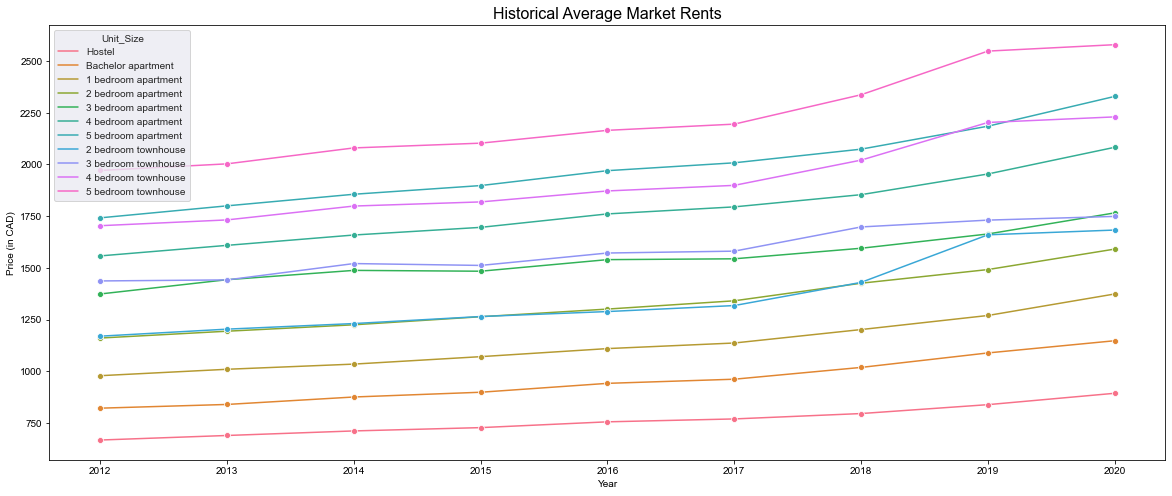

In [34]:
fig = plt.figure(figsize=(20,8))
plt.title("Historical Average Market Rents", fontsize = 16)
plt.ylabel('Price (in CAD)')
sns.set_style("darkgrid")
sns.lineplot(data = df_melted, x = 'Year', y = 'AMR', hue = 'Unit_Size',
                  markers = True, marker = 'o')

According to the graph above, AMR of **2 Bedroom Townhouse** aggresively increased from 2018 to 2019. <br> 


AMR of **4 Bedroom Townhouse** was higher than **5 Bedroom Apartment** in 2019. Tenants got more space with less cost in 2019.

<a id='discussion'></a>
## Discussion
<a id='discussion'></a>

The Kaggle dataset merely contains over one thousands of records with geographical information. To improve the mapping, I will replace the original dataset with a much larger dataset. <br>

Personally, I will choose the latter between bachlor unit and one-bed unit for larger space for myself and my cats, as AMR of one-bed units fits my budget. I would love a dedicated reading space and more room for cats to release their endless energy when they are awake.